In [1]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
folder_path = 'Z:\\Sasindu\\2_Discharge_ET_Madagascar\\2_Discharge_ET_Madagascar\\2c_Rainfall_ET_M'
blue_files = sorted(glob.glob(os.path.join(folder_path, '*.tif')))

In [3]:
def load_rasters(file_list):
    data_stack = []
    for f in file_list:
        with rasterio.open(f) as src:
            data = src.read(1)  # Read band 1
            data_stack.append(data)
    return np.array(data_stack)

In [4]:
blue_et_stack = load_rasters(blue_files)

In [5]:
print("Blue ET shape:", blue_et_stack.shape)

Blue ET shape: (228, 1433, 762)


In [20]:
def summary_stats(data_stack, name):
    flat = data_stack[~np.isnan(data_stack)]
    print(f"Stats for {name}")
    print("Min:", np.min(flat))
    print("Max:", np.max(flat))
    print("Mean:", np.mean(flat))
    print("Std Dev:", np.std(flat))

summary_stats(blue_et_stack, "Blue ET")

Stats for Blue ET
Min: 0.0
Max: 1394.4062
Mean: 49.328804
Std Dev: 42.61285


In [25]:
years = range(2003, 2022)
months = range(1, 13)

# Initialize an empty list to store monthly mean values
monthly_mean_values = []

# Loop through all months for each year
for year in years:
    for month in months:
        # Construct file path
        file_path = rf'Z:\Sasindu\2_Discharge_ET_Madagascar\2_Discharge_ET_Madagascar\2b_Incremental_ET_M\Madagascar__ETincr_{year}.{month:02d}.01.tif'
        
        try:
            # Open the .tif file and read the data
            with rasterio.open(file_path) as src:
                data = src.read(1)  # Read the first band (most common for rainfall/ET data)
                
                # Mask any NaN values in the data (if any)
                data = np.ma.masked_invalid(data)
                
                # Calculate the mean value for this month
                monthly_mean = data.mean()  # This ignores NaN values automatically
                monthly_mean_values.append((year, month, monthly_mean))
        
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            # Append a NaN if file can't be processed
            monthly_mean_values.append((year, month, np.nan))

In [26]:
import pandas as pd
df = pd.DataFrame(monthly_mean_values, columns=['Year', 'Month', 'Mean'])
df.head()

,Year,Month,Mean
0,2003,1,0.835459
1,2003,2,17.610618
2,2003,3,4.072233
3,2003,4,22.564450
4,2003,5,17.109564


In [28]:
df.shape

(228, 3)

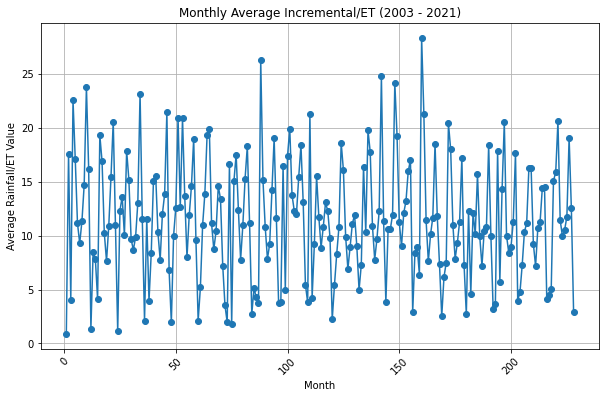

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(df['Month'] + 12 * (df['Year'] - 2003), df['Mean'], marker='o')  # Flatten the years and months for time-series
plt.title('Monthly Average Incremental/ET (2003 - 2021)')
plt.xlabel('Month')
plt.ylabel('Average Rainfall/ET Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

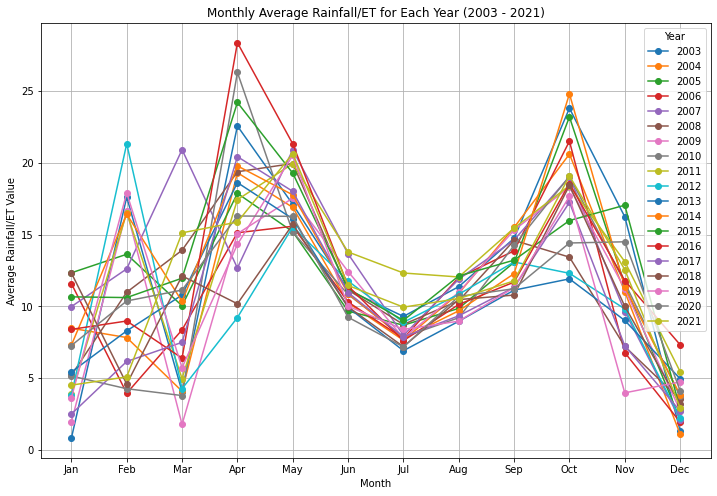

In [31]:
plt.figure(figsize=(12, 8))

for year in years:
    yearly_data = df[df['Year'] == year]
    plt.plot(yearly_data['Month'], yearly_data['Mean'], marker='o', label=str(year))

plt.title('Monthly Average Rainfall/ET for Each Year (2003 - 2021)')
plt.xlabel('Month')
plt.ylabel('Average Rainfall/ET Value')
plt.legend(title='Year')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

C:\Users\Maclan\AppData\Local\Temp\ipykernel_3324\4158326164.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_avg = df.groupby(['Year', 'Season'])['Mean'].mean().unstack()


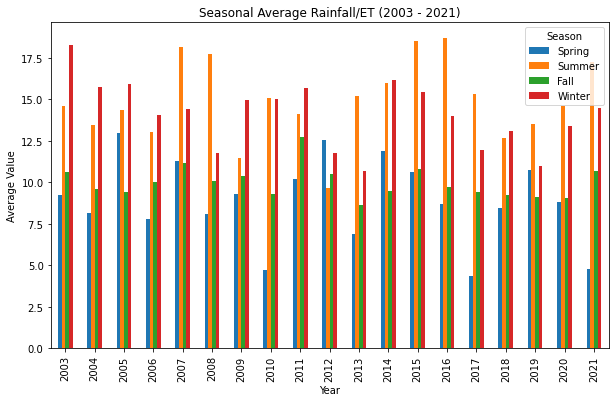

In [32]:
df['Season'] = pd.cut(df['Month'], bins=[0, 3, 6, 9, 12], labels=['Spring', 'Summer', 'Fall', 'Winter'], right=False)

# Calculate the seasonal averages
seasonal_avg = df.groupby(['Year', 'Season'])['Mean'].mean().unstack()
seasonal_avg.plot(kind='bar', figsize=(10, 6), title='Seasonal Average Rainfall/ET (2003 - 2021)')
plt.ylabel('Average Value')
plt.xlabel('Year')
plt.show()

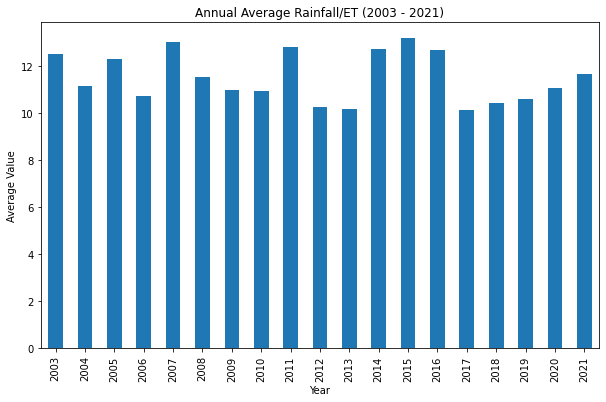

In [33]:
annual_avg = df.groupby('Year')['Mean'].mean()

# Plot the annual average values
annual_avg.plot(kind='bar', figsize=(10, 6), title='Annual Average Rainfall/ET (2003 - 2021)')
plt.ylabel('Average Value')
plt.xlabel('Year')
plt.show()

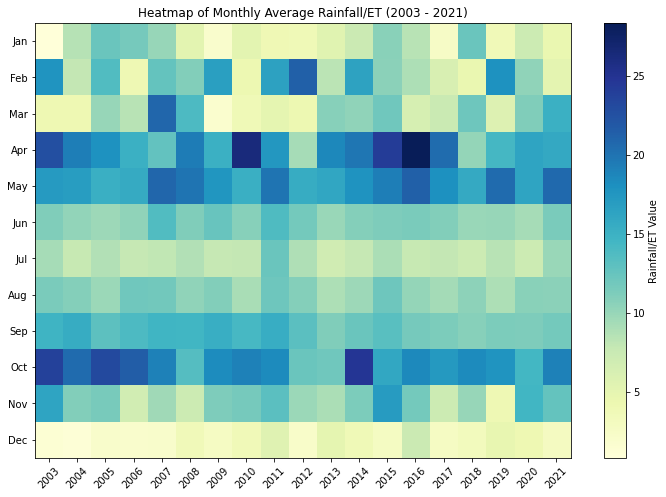

In [36]:
heatmap_data = df.pivot(index='Month', columns='Year', values='Mean')

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(heatmap_data, cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Rainfall/ET Value')
plt.title('Heatmap of Monthly Average Rainfall/ET (2003 - 2021)')
plt.xticks(ticks=np.arange(len(df['Year'].unique())), labels=df['Year'].unique(), rotation=45)
plt.yticks(ticks=np.arange(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

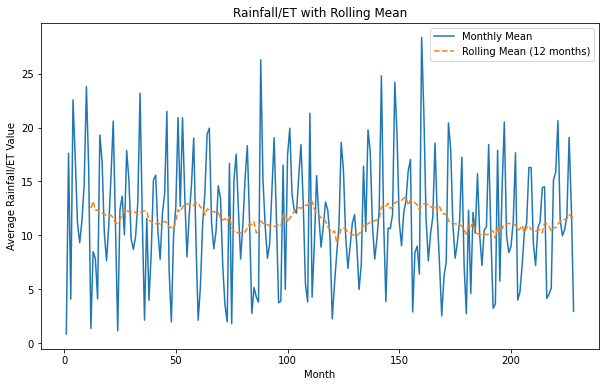

In [35]:
df['Rolling_Mean'] = df['Mean'].rolling(window=12).mean()

# Plot anomalies
plt.figure(figsize=(10, 6))
plt.plot(df['Month'] + 12 * (df['Year'] - 2003), df['Mean'], label='Monthly Mean')
plt.plot(df['Month'] + 12 * (df['Year'] - 2003), df['Rolling_Mean'], label='Rolling Mean (12 months)', linestyle='--')
plt.title('Rainfall/ET with Rolling Mean')
plt.xlabel('Month')
plt.ylabel('Average Rainfall/ET Value')
plt.legend()
plt.show()